In [ ]:
%%capture
!apt-get install tesseract-ocr
!pip install pytesseract
!pip install imutils
!sudo apt-get install tesseract-ocr-spa -y

In [ ]:
import os
import cv2
import pytesseract
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import imutils
from math import atan2, cos, sin, sqrt, pi
import numpy as np
import re

In [ ]:
# idiomas que podemos usar para deteccion
print(pytesseract.get_languages())

['eng', 'osd', 'spa']


In [ ]:
# Conectamos a GoogleDrive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
BASE_PATH = "/content/drive/My Drive/AI - Proyecto Final/DataSet/images_raw/"

In [ ]:
def calculate_orientation(img):
  # Convert image to grayscale
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  # Convert image to binary
  _, bw = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
  # Find all the contours in the thresholded image
  contours, _ = cv2.findContours(bw, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
  for i, c in enumerate(contours):
    # Calculate the area of each contour
    area = cv2.contourArea(c)
    # Ignore contours that are too small or too large
    if area < 3700 or 100000 < area:
      continue
    # cv.minAreaRect returns:
    # (center(x, y), (width, height), angle of rotation) = cv2.minAreaRect(c)
    rect = cv2.minAreaRect(c)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    # Retrieve the key parameters of the rotated bounding box
    center = (int(rect[0][0]),int(rect[0][1])) 
    width = int(rect[1][0])
    height = int(rect[1][1])
    angle = int(rect[2])

    if width < height:
      angle = 90 - angle
    else:
      angle = -angle
    
    return angle

In [ ]:
def tesseract_text_orientation(img):
  rotated_image = img
  try:
    output = pytesseract.image_to_osd(img, config='--psm 0')
    print('tesseract output', output)
    angle = re.search(r'Orientation in degrees: \d+', output).group().split(':')[-1].strip()
    print('##### angleee ####', angle)
    if angle == '90':
      rotated_image = cv2.rotate(rotated_image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    if angle == '180':
      rotated_image = cv2.rotate(rotated_image, cv2.ROTATE_180)
    if angle == '270':
      rotated_image = cv2.rotate(rotated_image, cv2.ROTATE_90_CLOCKWISE)
    elif angle != 0:    
      rotated_image = calculate_orientation(rotated_image)
  except Exception as e:
    print('error on tesseract_text_orientation:', e)
  finally:
    return rotated_image

In [ ]:
def load_img(filename):
    img_resized = filename 
    img = cv2.imread(img_resized)
    try:
      height, width, channels = img.shape
      img_resized = cv2.resize(img,(width,height))
    except:
        print(f'Error on image {img}')
    finally:
      return img_resized

In [ ]:
def process_grey(img):
  return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert the image to gray scale

def process_gamma(img, gamma=3):
  lookUpTable = np.empty((1,256), np.uint8)
  for i in range(256):
      lookUpTable[0,i] = np.clip(pow(i / 255.0, gamma) * 255.0, 0, 255)
  return cv2.LUT(img, lookUpTable)

def process_blur(img, kernel=19):
  return cv2.GaussianBlur(img, (kernel, kernel), 0) # Add Gaussian blur

def process_canny(img, threshold1=30, threshold2=50, apperture=3):
  return cv2.Canny(img, threshold1, threshold2, apperture) # Apply the Canny algorithm to find the edges

def process_black_and_white(img):
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    (thresh, BnW_image) = cv2.threshold(gray_image, 125, 255, cv2.THRESH_BINARY)
    return BnW_image

def process_blurnes_and_correct(img):
  process = img
  gray = cv2.cvtColor(process, cv2.COLOR_BGR2GRAY)
  fm = cv2.Laplacian(gray, cv2.CV_64F).var()
  print('#### fmmm ####',  fm)
  if fm > 150:
    sharpen = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    process = cv2.filter2D(img, -1, sharpen)
  return process

def process_rescale(img):
  scale_percent = 220 # percent of original size
  width = int(img.shape[1] * scale_percent / 100)
  height = int(img.shape[0] * scale_percent / 100)
  dim = (width, height)
  image = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  return image


In [ ]:
gamma_value = 2  #@param {type:"slider", min:1, max:10, step:1}
blur_kernel = 1 #@param {type:"slider", min:1, max:99, step:2}
canny_t1 = 71 #@param {type:"slider", min:1, max:1000}
canny_t2 = 88 #@param {type:"slider", min:1, max:1000}
canny_apperture = 1 #@param {type:"slider", min:1, max:10, step:1}

def process_image(image):
  result = image
  result = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  result = tesseract_text_orientation(result)
  result = process_rescale(result)
  #result = process_blurnes_and_correct(result)
  #result = process_gamma(result, gamma_value)
  #result = process_blur(result, blur_kernel)
  #result = process_canny(result, canny_t1, canny_t2, canny_apperture)
  #result = process_grey(result)
  #result = process_black_and_white(result)
  return result

In [ ]:
def transform_image(img):
    img_resized = img 
    try:
      img_resized = process_image(img_resized)
    except Exception as error:
        print(f'Error on transform image : {error}')
    finally:
      return img_resized

In [ ]:
def process_ocr(img):
  custom_config = r'--oem 3 --psm 5 --psm 6'
  return pytesseract.image_to_string(img, lang='spa', config=custom_config)

In [ ]:
IMG_DIR_TEST_OK = BASE_PATH + 'Remito_OK'

data_test_ok = []
for filename in os.listdir(IMG_DIR_TEST_OK):
  data_test_ok.append({"image_name": filename, "angle": None, 'data_bruto': None})

df_result = pd.DataFrame(data_test_ok)
df_result

,image_name,angle,data_bruto
0,1660.jpg,None,None
1,1681.jpg,None,None
2,1968.jpg,None,None
3,1996.jpg,None,None
4,1997.jpg,None,None
...,...,...,...
190,IMG_20220817_114351.jpg,None,None
191,IMG_20220817_114357.jpg,None,None
192,IMG_20220817_114411.jpg,None,None
193,11841.jpg,None,None


In [ ]:
angle_df = []
for index, row in df_result.iterrows():
  img_path = IMG_DIR_TEST_OK + '/' + row['image_name']
  try:
    img = load_img(img_path)
    angle = calculate_orientation(img)
    angle_df.append(angle)
  except Exception as e:
    print('No se procesa img', e)

df_result['angle'] = angle_df
df_result

,image_name,angle,data_bruto,data_tara,data_neto
0,1660.jpg,-90.0,0,0,0
1,1681.jpg,0.0,0,26250,3940
2,1968.jpg,0.0,0,0,2
3,1996.jpg,0.0,42050,0,13.940
4,1997.jpg,0.0,28.110,17.260,10850
...,...,...,...,...,...
190,IMG_20220817_114351.jpg,89.0,0,0,0
191,IMG_20220817_114357.jpg,-2.0,39.560,36.320,3.240
192,IMG_20220817_114411.jpg,-87.0,42.290,34.980,7.310
193,11841.jpg,0.0,22590,16.890,5.700


In [ ]:
def extract_bruto_from_text(text):
  t = text.upper()
  print(t)
  #t = t.replace('—','') # a veces viene este caracter en la salida del OCR
  r = '(BRUTO\: *|BRUTO *) *(?P<bruto>\d+\.*\d*)'
  res = re.search(r, t)
  if res is not None:
    t = res.group('bruto')
    bruto = t
    return bruto
  return 0

In [ ]:
def extract_neto_from_text(text):
  t = text.upper()
  print(t)
  #t = t.replace('—','') # a veces viene este caracter en la salida del OCR
  r = '(NETO\: *|NETO *) *(?P<neto>\d+\.*\d*)'
  res = re.search(r, t)
  if res is not None:
    t = res.group('neto')
    neto = t
    return neto
  return 0

In [ ]:
def extract_tara_from_text(text):
  t = text.upper()
  print(t)
  #t = t.replace('—','') # a veces viene este caracter en la salida del OCR
  r = '(TARA\: *|TARA *) *(?P<tara>\d+\.*\d*)'
  res = re.search(r, t)
  if res is not None:
    t = res.group('tara')
    tara = t
    return tara
  return 0

error on tesseract_text_orientation: (1, 'Tesseract Open Source OCR Engine v4.0.0-beta.1 with Leptonica Warning. Invalid resolution 0 dpi. Using 70 instead. Estimating resolution as 170 Too few characters. Skipping this page Error during processing.')
L BOLETA DE PESADA
ROLESA ERRO COIE C00A MO LR E
ORG POETA DE ASCELIACIÓN — PESTINAS BAMED E LAZA
' OPERADOR
UA: JUL PEAR CANI NL
A ' > |
LESNSTER REÑA OIA BRUTO: 28.110 KG |
5% PA TARA: 17.260 KG
PL MICRA NETO: 10850 KG |
PDISSERVACIONES: — ELNIQA1AD MAT: 20301 BRITOS DE LESTA AL UR 2
IAA

28.110
L BOLETA DE PESADA
ROLESA ERRO COIE C00A MO LR E
ORG POETA DE ASCELIACIÓN — PESTINAS BAMED E LAZA
' OPERADOR
UA: JUL PEAR CANI NL
A ' > |
LESNSTER REÑA OIA BRUTO: 28.110 KG |
5% PA TARA: 17.260 KG
PL MICRA NETO: 10850 KG |
PDISSERVACIONES: — ELNIQA1AD MAT: 20301 BRITOS DE LESTA AL UR 2
IAA

10850
L BOLETA DE PESADA
ROLESA ERRO COIE C00A MO LR E
ORG POETA DE ASCELIACIÓN — PESTINAS BAMED E LAZA
' OPERADOR
UA: JUL PEAR CANI NL
A ' > |
LESNSTER RE

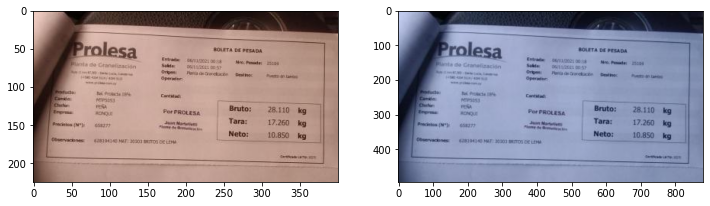

In [ ]:
fig = plt.figure(figsize=(12, 12))
columns = 2
rows = 2


PATH = BASE_PATH + 'Remito_OK'
image_path = PATH + '/1997.jpg'
image = load_img(image_path)
fig.add_subplot(rows, columns, 1)
plt.imshow(image)
transformed = transform_image(image)
fig.add_subplot(rows, columns, 2)
plt.imshow(transformed)
text = process_ocr(transformed)
print(extract_bruto_from_text(text))
print(extract_neto_from_text(text))
print(extract_tara_from_text(text))

In [ ]:
%%capture
brutos = []
taras = []
netos = []
for index, row in df_result.iterrows():
  img_path = IMG_DIR_TEST_OK + '/' + row['image_name']
  try:
    img = load_img(img_path)
    transformed = transform_image(img)
    text = process_ocr(transformed)
    bruto = extract_bruto_from_text(text)
    tara = extract_tara_from_text(text)
    neto = extract_neto_from_text(text)
    brutos.append(bruto)
    taras.append(tara)
    netos.append(neto)
  except Exception as e:
    print('No se procesa img', e)

df_result['data_bruto'] = brutos
df_result['data_tara'] = taras
df_result['data_neto'] = netos
df_result

In [ ]:
df_result.to_csv(BASE_PATH + 'df_salida_ocr.csv')  